# Create CIGALE input files
Here we create the photometry files that we use as an input to [CIGALE](https://cigale.lam.fr/) (We actually use X-CIGALE, but most of the information can be found in the same web page) . First we import important packages.

In [1]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.units as u
from astropy import coordinates
from astropy.table import Table, vstack, unique, join, Column

from os import path
from numpy import unique as uniq

We read the SMB-VCV sample file and create a table of equivalencies between the different bands.

In [3]:
FinalName = Table.read('VCV_TAP_otype.txt', format='ascii')
Sample = uniq(FinalName)

## Create equivalences between NED and CDS tables
Here we create a list for the different names of the bands in NED and CDS that represent the same band.

In [4]:
Equival = [['2-10 keV (XMM)', None, None],
           ['0.5-2 keV (XMM)', None, None],
           ['GALEX:FUV', 'FUV (GALEX)', None],
           ['GALEX:NUV', 'NUV (GALEX)', None],
           ["SDSS:u'", 'SDSS:u', 'u (SDSS) AB'],
           ["SDSS:g'", 'SDSS:g', 'g (SDSS) AB'],
           ["SDSS:r'", 'SDSS:r', 'r (SDSS) AB'],
           ["SDSS:i'", 'SDSS:i', 'i (SDSS) AB'],
           ["SDSS:z'", 'SDSS:z', 'z (SDSS) AB'],
           ['2MASS:J', 'J (2MASS) AB', None],
           ['2MASS:H', 'H (2MASS) AB', None],
           ['2MASS:Ks', 'Ks (2MASS) AB', None],
           ['WISE:W1', 'W1 (WISE)', None],
           [':=3.6um', '3.6 microns (IRAC)', None],
           [':=4.5um', '4.5 microns (IRAC)', None],
           ['WISE:W2', 'W2 (WISE)', None],
           [':=5.8um', '5.8 microns (IRAC)', None],
           [':=8um', '8.0 microns (IRAC)', None],
           ['IRAS:12', '12 microns (IRAS)', None],
           ['WISE:W3', 'W3 (WISE)', None],
           ['WISE:W4', 'W4 (WISE)', None],
           ['Spitzer/MIPS:24', '24 microns (MIPS)', None],
           ['IRAS:25', '25 microns (IRAS)', None],
           ['IRAS:60', '60 microns (IRAS)', None],
           ['Herschel/PACS:70', '70 microns (PACS)', None],
           ['Spitzer/MIPS:70', '70 microns (MIPS)', None],
           ['IRAS:100', '100 microns (IRAS)', None],
           ['Herschel/PACS:100', '100 microns (PACS)', None],
           ['Spitzer/MIPS:160', '160 microns (MIPS)', None],
           ['Herschel/PACS:160', '160 microns (PACS)', None],
           ['Herschel/SPIRE:250', '250 microns (SPIRE)', ':=250um'],
           ['Herschel/SPIRE:350', '350 microns (SPIRE)', ':=350um'],
           ['Herschel/SPIRE:500', '500 microns (SPIRE)', ':=500um'],
           [':=5GHz', ':=6cm', '4.89 GHz (VLA)'],
           [':=1.5GHz', ':=20cm', '1.46 GHz (VLA)'],
           [':=1.4GHz', ':=21cm', '1.4GHz']
           ]

## Transform to CIGALE

We create a class that allow us to transform the units of the SEDs in the selected bands

In [5]:
class TransformCIGALE:
    def __init__(self,SED):
        self.sed = SED 
#         self.Iniplot() # To check the SED
        self.CreateRow()
    
    def Iniplot(self):
        errorbar(self.sed['Wave'],self.sed['Flux'],yerr=self.sed['F_er'],fmt='o')
        xlim(1e-6,1e6)
        loglog()
        
    def CreateRow(self):
        self.row=full(72,nan)#full(68,nan)## Number of filtets/bands and their errors
        iLos=0
        for LOS in Equival:
            Crop=self.sed[np.logical_or.reduce([self.sed['Filter']==LOS[0],self.sed['Filter']==LOS[1],self.sed['Filter']==LOS[2]])]
            Flux=np.mean(Crop['Flux'])
            Std=np.sqrt(np.sum(Crop['F_er']**2))/len(Crop)
            self.row[iLos]=Flux*1000#To send in mJy
            self.row[iLos+1]=Std*1000#To send in mJy
            iLos+=2
#             if ~isnan(Flux):
#                 errorbar(Crop[0]['Wave'],Flux,yerr=Std,fmt='o',c='C1')
#                 loglog()            

We create a table with all the CIGALE bands/filters and fill it with the information that we get from NED and CDS. In some cases some of the galaxies are not useful because the bands are not found initially. This could take some minutes.

In [6]:
CIGALEFilter=['xray_box_car_2to10keV','xray_box_car_0p5to2keV','FUV','NUV','u_prime','g_prime','r_prime','i_prime','z_prime','J_2mass','H_2mass','Ks_2mass',
              'WISE1','IRAC1','IRAC2','WISE2','IRAC3','IRAC4','IRAS1','WISE3','WISE4','MIPS1','IRAS2',
              'IRAS3','PACS_blue','MIPS2','IRAS4','PACS_green','MIPS3','PACS_red','PSW_ext','PMW_ext','PLW_ext',
              'VLA_C','VLA_L','HI21cm']
# VLAC is 6cm ,VLAL is 20 cm and HI21cm is 1.4GHz
As=[]
[As.append([s,s+'_err']) for s in CIGALEFilter]
CIG= Table(names=array(As).ravel())
GoodGalaxies=[]

for igal,Galaxy in enumerate(Sample['main_id']):
#     figure()
    SED=Table.read('SEDs/'+Galaxy+'_Phot.txt',format='ascii')
    if len(SED)==0:
        print(Galaxy,'No useful phot.')
    else:
        GoodGalaxies.append(igal)
        CIG.add_row(TransformCIGALE(SED).row)

/Users/users/ramos/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3370: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/users/ramos/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/users/ramos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


1RXS J042710.2-624712 No useful phot.
2E  3952 No useful phot.
2QZ J014222.6-272036 No useful phot.
2QZ J020832.4-294706 No useful phot.
2QZ J024658.5-300919 No useful phot.
2QZ J214709.3-312146 No useful phot.
2QZ J214750.4-303316 No useful phot.
2QZ J214851.8-274658 No useful phot.
2QZ J220354.6-280400 No useful phot.
2QZ J220624.1-313407 No useful phot.
2QZ J221655.1-310212 No useful phot.
2QZ J225111.4-273548 No useful phot.
2QZ J225550.1-281609 No useful phot.
BOI 3C 295  48 No useful phot.
CAIRNS J130609.11+285028.6 No useful phot.
CLASXS  36 No useful phot.
CLASXS  74 No useful phot.
CLASXS 305 No useful phot.
CXOCY J033720.9-050352 No useful phot.
CXOCY J033747.8-050721 No useful phot.
CXOCY J033754.2-050915 No useful phot.
CXOCY J033756.3-045509 No useful phot.
CXOCY J125306.5-092137 No useful phot.
CXOCY J125314.6-091619 No useful phot.
HELLAS2XMM 03120035 No useful phot.
HELLAS2XMM 05370016 No useful phot.
HELLAS2XMM 50900067 No useful phot.
HELLAS2XMM J031254.0-765415 No us

In [7]:
# for ias in CIG.colnames[2:]:
#     print(ias,sum(~isnan(CIG[ias])))

In [8]:
# ## Section to check the radio-loud galaxies (None is roud loud)
# from astropy.cosmology import Planck15
# CIG['Distance']=Planck15.luminosity_distance(CIG['redshift']).value
# CIG['L_1.4GHz']=((u.Jy *CIG['HI21cm']*4*np.pi*CIG['Distance']**2 *u.Mpc**2)/(1+CIG['redshift'])**(1+2)).to(u.W/u.Hz)
# print(nanmax(CIG['L_1.4GHz']))

After some consideration we need to remove the filters in the radio wavelengths as they provide information only in a few cases and adding the modules of X-ray and radio and CIGALE only for a few sources is not justified. 

In [9]:
CIG= CIG[CIG.colnames[4:-6]] ## Remove x-ray and radio wavelengths

We add the identifier (main_id) and the redshift from SIMBAD. 

In [10]:
col_name = Column(name='id', data=Sample['main_id'][GoodGalaxies])
CIG.add_column(col_name, 0)
col_z = Column(name='redshift', data=Sample['rvz_redshift'][GoodGalaxies])
CIG.add_column(col_z, 1)

## Clean values and remove bad galaxies

Then for each filter we verify if the relative error is higher than 33%, in those cases we do not use that information. Also we remove information with limits (that in some cases are annoted as negative values). 

In [11]:
for igal in range(len(CIG)):
    for icol in CIG.colnames[2::2]:
        if CIG[icol+'_err'][igal]/CIG[icol][igal] >=1/3.:#Higher than 33%
            print(CIG['id'][igal],icol, CIG[icol+'_err'][igal]/CIG[icol][igal])
            CIG[icol+'_err'][igal] = np.nan
            CIG[icol][igal]        = np.nan
        if CIG[icol+'_err'][igal]/CIG[icol][igal] <=0:##Negative Limits
            print('Negative',CIG['id'][igal],icol)
            CIG[icol+'_err'][igal] = np.nan
            CIG[icol][igal]        = np.nan

1RXP J131831.5+332038 NUV 0.3879891000264723
1RXS J003541.9+004747 J_2mass 0.40213938024029505
1RXS J003541.9+004747 H_2mass 0.4083735756526766
1RXS J003541.9+004747 Ks_2mass 0.339285702098153
1RXS J004411.1+161042 WISE4 0.3566501261828649
1RXS J004549.6+155529 H_2mass 0.3686006951091558
1RXS J004549.6+155529 Ks_2mass 0.3375488927725338
1RXS J004549.6+155529 WISE4 0.6562052867836473
1RXS J004742.3-004249 FUV 0.3689622738022665
1RXS J004742.3-004249 H_2mass 0.34862044801384723
1RXS J013338.9+002506 FUV 0.48010600883873344
1RXS J013338.9+002506 NUV 0.33526998030457633
1RXS J013338.9+002506 WISE4 0.3461884637265613
1RXS J025206.2-075739 J_2mass 0.4549538955178483
1RXS J025206.2-075739 H_2mass 0.4275213363478086
1RXS J025206.2-075739 Ks_2mass 0.35807062545069807
1RXS J031715.1+010352 FUV 0.521757337864414
1RXS J031715.1+010352 NUV 0.42588144237986364
1RXS J031715.1+010352 J_2mass 0.34384801113909963
1RXS J031715.1+010352 WISE4 0.38160362408140275
1RXS J033627.1-055148 WISE4 0.4278850744070

2MASS J03424773+0109331 WISE4 0.42036718180815436
2MASS J03440602-0707164 FUV 0.36478581890992623
2MASS J03440602-0707164 J_2mass 0.4778071091566912
2MASS J03440602-0707164 H_2mass 0.3617877056018238
2MASS J03440602-0707164 Ks_2mass 0.40692096353245977
2MASS J03443002-0058428 J_2mass 0.4930181725463991
2MASS J03443002-0058428 Ks_2mass 0.5502183466441631
2MASS J03443002-0058428 WISE4 0.4484111234764184
2MASS J03460548-0531590 J_2mass 0.4372327161099742
2MASS J03460548-0531590 H_2mass 0.40255277981351917
2MASS J03460548-0531590 Ks_2mass 0.35944967736969174
2MASS J03490089-0453392 J_2mass 0.7371881103147531
2MASS J03490089-0453392 H_2mass 0.6198294355348362
2MASS J03490089-0453392 Ks_2mass 0.6132299818992959
2MASS J03490089-0453392 WISE4 0.3934426229508196
2MASS J03490876-0620188 J_2mass 0.49943161499838173
2MASS J03490876-0620188 H_2mass 0.5944418088993454
2MASS J03490876-0620188 Ks_2mass 0.5284780593080971
2MASS J03490876-0620188 WISE4 0.4204264672638391
2MASS J03491607-0622291 J_2mass 

2MASS J09023962+2413560 WISE4 0.5275411620100667
2MASS J09033546+0132242 J_2mass 0.42144956781067594
2MASS J09033546+0132242 H_2mass 0.4092856178566218
2MASS J09035151+2901591 J_2mass 0.4449732285509838
2MASS J09035151+2901591 H_2mass 0.5886914159156281
2MASS J09035151+2901591 Ks_2mass 0.4539448845124393
2MASS J09035992+3630548 u_prime 0.33903134460915213
2MASS J09035992+3630548 H_2mass 0.5271727358317123
2MASS J09035992+3630548 Ks_2mass 0.3455090430896065
2MASS J09042731+3743574 J_2mass 0.37231418659742693
2MASS J09042731+3743574 H_2mass 0.41520305720740663
2MASS J09043121+0753308 FUV 0.3555415905373971
2MASS J09043121+0753308 J_2mass 0.34148384473818316
2MASS J09043222+5538303 J_2mass 0.3942530500876895
2MASS J09043222+5538303 H_2mass 0.39981808686789594
2MASS J09044819+4202198 J_2mass 0.606060623598092
2MASS J09044819+4202198 H_2mass 0.5403726588167069
2MASS J09044819+4202198 Ks_2mass 0.4256642741818786
2MASS J09045499+5114445 H_2mass 0.3530831164948863
2MASS J09050150+1643257 FUV 0

2MASS J10360850+6002302 FUV 0.36902883386446295
2MASS J10360850+6002302 J_2mass 0.6882352732463716
2MASS J10360850+6002302 Ks_2mass 0.39185055818200676
2MASS J10361564+0319172 J_2mass 0.5567190922734464
2MASS J10361564+0319172 H_2mass 0.5541492802494496
2MASS J10361564+0319172 Ks_2mass 0.5132451485782423
2MASS J10365794+3457387 J_2mass 0.5691818154760808
2MASS J10365794+3457387 H_2mass 0.6562118667362982
2MASS J10365794+3457387 Ks_2mass 0.4626246707090882
2MASS J10365794+3457387 WISE4 0.36399525722590864
2MASS J10372152+4519519 J_2mass 0.3468825840542894
2MASS J10372152+4519519 Ks_2mass 0.38628987083045124
2MASS J10372152+4519519 WISE3 0.42429208622112013
2MASS J10373564+4030574 J_2mass 0.3760627569149679
2MASS J10373564+4030574 H_2mass 0.4638568550111986
2MASS J10373564+4030574 Ks_2mass 0.4199605110181076
2MASS J10373564+4030574 WISE4 0.3770672736202086
2MASS J10375469+5251336 FUV 0.4673028982093541
2MASS J10375469+5251336 J_2mass 0.7411588800345765
2MASS J10375469+5251336 H_2mass 0.7

2MASS J12023880+4711447 NUV 0.3522235963022505
2MASS J12023880+4711447 J_2mass 0.41425715872657254
2MASS J12023880+4711447 H_2mass 0.41416598775242086
2MASS J12024348+1437293 J_2mass 0.48029896450704723
2MASS J12024348+1437293 H_2mass 0.6438695659607749
2MASS J12024348+1437293 Ks_2mass 0.3943115944226716
2MASS J12024348+1437293 WISE4 0.453545275874695
2MASS J12025534+2615189 NUV 0.4413875698065419
2MASS J12025534+2615189 u_prime 0.39715400288336156
2MASS J12025534+2615189 H_2mass 0.38989887755405406
2MASS J12025626+1029173 NUV 0.41825093818707626
2MASS J12031211+0153216 J_2mass 0.4953400844693303
2MASS J12031211+0153216 H_2mass 0.5539856468435179
2MASS J12031211+0153216 Ks_2mass 0.3999999925599878
2MASS J12035476+3711369 J_2mass 0.38210297299077356
2MASS J12035476+3711369 H_2mass 0.47016102941511195
2MASS J12040744+3832444 J_2mass 0.4121107794188139
2MASS J12040744+3832444 H_2mass 0.5124942111242662
2MASS J12040744+3832444 Ks_2mass 0.4387755788108824
2MASS J12041179+1350118 FUV 0.50539

2MASS J13453281+0912398 H_2mass 0.47726952028466635
2MASS J13453281+0912398 Ks_2mass 0.388711249366125
2MASS J13453711+1224033 J_2mass 0.4753828107538614
2MASS J13453711+1224033 H_2mass 0.49369607442944746
2MASS J13453711+1224033 Ks_2mass 0.5135698855765752
2MASS J13453776+6331303 J_2mass 0.525544036259448
2MASS J13453776+6331303 H_2mass 0.6128639689578028
2MASS J13462954+1052265 J_2mass 0.3375743854313658
2MASS J13462954+1052265 H_2mass 0.3535688056623521
2MASS J13463496+3121336 FUV 0.33376153327489383
2MASS J13463496+3121336 J_2mass 0.5996730045199952
2MASS J13463496+3121336 H_2mass 0.490221076463416
2MASS J13463496+3121336 PACS_green 0.7278797912643374
2MASS J13463496+3121336 PACS_red 0.7579298743899294
2MASS J13463496+3121336 PMW_ext 0.43085107004506906
Negative 2MASS J13463496+3121336 PLW_ext
2MASS J13463609+1344346 H_2mass 0.33529137590007807
2MASS J13464006-0300125 J_2mass 0.6283602377381813
2MASS J13464006-0300125 H_2mass 0.40057035105023686
2MASS J13464006-0300125 Ks_2mass 0.5

2MASS J15204640+3643455 J_2mass 0.450340660493606
2MASS J15204640+3643455 H_2mass 0.3591517731876036
2MASS J15204640+3643455 Ks_2mass 0.4114206594816617
2MASS J15210640+3708038 FUV 0.3712310634372683
2MASS J15210640+3708038 J_2mass 0.37423469310324115
2MASS J15211403+0115070 H_2mass 0.3455464479834666
2MASS J15212588+5409463 J_2mass 0.353063355760297
2MASS J15212588+5409463 H_2mass 0.3475753111441536
2MASS J15212588+5409463 Ks_2mass 0.3688359611638821
2MASS J15215387+0829156 FUV 0.3423294720184979
2MASS J15215387+0829156 J_2mass 0.3619809157839808
2MASS J15215387+0829156 H_2mass 0.3396895899686464
2MASS J15215387+0829156 Ks_2mass 0.4754084191690409
2MASS J15221372+0101177 J_2mass 0.547106881341814
2MASS J15221372+0101177 H_2mass 0.4279091555442891
2MASS J15221372+0101177 Ks_2mass 0.4623294725506702
2MASS J15222072+2543322 J_2mass 0.5918678046842221
2MASS J15222072+2543322 H_2mass 0.6648194551026331
2MASS J15222072+2543322 Ks_2mass 0.3624732931531809
2MASS J15222072+2543322 WISE4 0.5266

2MASS J21493523+1138422 NUV 0.7657293710710822
2MASS J21493523+1138422 Ks_2mass 0.3710128317803048
2MASS J21515100-1946056 J_2mass 0.3575339540188062
2MASS J21515100-1946056 H_2mass 0.3831565614321243
2MASS J21523239+1153509 J_2mass 0.4441340903347152
2MASS J21523239+1153509 H_2mass 0.3994334160350394
2MASS J21533963+1157376 J_2mass 0.33478218997423886
2MASS J21533963+1157376 H_2mass 0.3634050446551254
2MASS J21533963+1157376 WISE4 0.43738952750483745
2MASS J21534555+1741477 J_2mass 0.351055063114102
2MASS J21534555+1741477 H_2mass 0.40827080990083875
2MASS J21534555+1741477 Ks_2mass 0.42944350112153495
2MASS J21551613+0032508 H_2mass 0.3464101962510576
2MASS J21583323+0112552 FUV 0.6705107512965095
2MASS J21583323+0112552 J_2mass 0.6030190538287327
2MASS J21583323+0112552 H_2mass 0.367092377097374
2MASS J21583323+0112552 WISE4 0.46218555098962316
2MASS J22040840+1136037 J_2mass 0.5564276783030018
2MASS J22040840+1136037 H_2mass 0.7632705119524787
2MASS J22040840+1136037 Ks_2mass 0.553

2MASX J03210936-0012513 FUV 0.38396271718701924
2MASX J03210936-0012513 NUV 0.3364415375456344
2MASX J03210936-0012513 WISE4 0.46396398328779326
2MASX J03225800+0003149 NUV 0.455580869939356
2MASX J03225887-0639032 H_2mass 0.404691852687829
2MASX J03225887-0639032 WISE3 0.4477214507951337
2MASX J03232585-0034194 WISE4 0.4931328632568454
2MASX J03233861+0038449 FUV 0.5075953424853686
2MASX J03250901-0639000 FUV 0.38757149114904893
2MASX J03250901-0639000 Ks_2mass 0.40501101358510994
2MASX J03250901-0639000 WISE4 0.34713382664826087
2MASX J03254170-0011167 FUV 0.37342534895695145
2MASX J03254170-0011167 NUV 0.3358791068742775
2MASX J03260604-0733466 FUV 0.33333334259616654
2MASX J03260604-0733466 NUV 0.4270346007301652
2MASX J03260674+0114297 NUV 0.35023384986722733
2MASX J03263173-0113044 WISE4 0.3770388308095424
2MASX J03265092-0628524 NUV 0.374397811421454
2MASX J03272521-0636519 FUV 0.42320464559657256
2MASX J03272990-0059589 H_2mass 0.3964163375631167
2MASX J03281166-0011217 FUV 0.3

2MASX J09311638+6153047 FUV 0.419453398069339
2MASX J09315804+3756322 FUV 0.6173361662565795
2MASX J09315804+3756322 NUV 0.36404019235235857
2MASX J09315804+3756322 J_2mass 0.423447286157459
2MASX J09315804+3756322 H_2mass 0.6455269672349374
2MASX J09315804+3756322 Ks_2mass 0.37154840277908335
2MASX J09315804+3756322 WISE4 0.3584236770191779
2MASX J09320260+3529277 FUV 0.42281142967547264
2MASX J09322712+5559387 FUV 0.4125636664426921
2MASX J09322712+5559387 WISE4 0.3393544207091588
2MASX J09323970+4106101 H_2mass 0.3760346764225842
2MASX J09330889+5347485 H_2mass 0.3628318580982794
2MASX J09335948+6109063 NUV 0.5206844361887242
2MASX J09344753+6800337 FUV 0.3697536779973606
2MASX J09345834+6112343 FUV 0.7366619800252837
2MASX J09345834+6112343 J_2mass 0.3804048226664011
2MASX J09345834+6112343 H_2mass 0.400708366569784
2MASX J09345834+6112343 WISE4 0.4947124045914374
2MASX J09352144-0004006 FUV 0.4065934142234305
2MASX J09352144-0004006 NUV 0.4067473109495558
2MASX J09352144-0004006 W

2MASX J12384274+4518246 FUV 0.7393653220587612
2MASX J12384274+4518246 NUV 0.5812542676840474
2MASX J12385497+6816005 WISE3 0.37509370675021536
2MASX J12392281+4052322 J_2mass 0.37081555750737016
2MASX J12392281+4052322 WISE4 0.3862171855599894
2MASX J12403777+3534379 FUV 0.3504531710439859
2MASX J12423849+1529351 FUV 0.3958375525641752
2MASX J12424677+6744323 H_2mass 0.42971279717171507
2MASX J12424677+6744323 Ks_2mass 0.3387645540347524
2MASX J12425674+0037525 FUV 0.536860632661381
2MASX J12425674+0037525 NUV 0.3633288531879152
2MASX J12430701+4212314 FUV 0.3344111201149479
2MASX J12430701+4212314 WISE4 0.7700920154268079
2MASX J12430866+0143432 WISE4 0.3889581131195452
2MASX J12431998+0252562 H_2mass 0.3622249027891996
2MASX J12434231+6525548 NUV 0.3932920948654958
2MASX J12440160-0201315 WISE3 0.4309915360944226
2MASX J12440655+6529249 FUV 0.4776435042187496
2MASX J12444595+6025485 IRAS2 0.38115942028985506
2MASX J12451551-0141487 FUV 0.5723835501514278
2MASX J12455060+0120278 J_2m

2MASX J15160942+0408481 H_2mass 0.3357356798055689
2MASX J15160942+0408481 Ks_2mass 0.35111811084876376
2MASX J15161469-0049112 WISE4 0.4726027210469724
2MASX J15162062+5856162 NUV 0.33903134460915213
2MASX J15165245+3954131 FUV 0.6862071256881949
2MASX J15171490+0322043 FUV 0.45995273557442135
2MASX J15173941+0407093 FUV 0.37183066718480523
2MASX J15173941+0407093 WISE4 0.38055314405077717
2MASX J15183888+4045005 FUV 0.4890219343519492
2MASX J15183888+4045005 WISE4 0.44299982366186375
2MASX J15193763+5742348 WISE4 0.46491230134822226
2MASX J15205906-0053529 NUV 0.3838798949030047
2MASX J15210153+0356491 NUV 0.3374181091705461
2MASX J15210153+0356491 WISE4 0.504916537078866
2MASX J15213223+4113395 H_2mass 0.3524426510961278
2MASX J15213500+3206384 H_2mass 0.4559805278457526
2MASX J15215743+2859180 NUV 0.5077085927551552
2MASX J15220380+0011283 J_2mass 0.3478941314552386
2MASX J15220380+0011283 H_2mass 0.38776065597733195
2MASX J15220548+3016447 NUV 0.6362155164363186
2MASX J15222834+02

2QZ J000950.3-300537 Ks_2mass 0.45280376143878515
2QZ J000950.3-300537 WISE4 0.49481319340835633
2QZ J001008.1-273041 WISE3 0.4251398023532302
2QZ J001058.5-295505 NUV 0.35463455882652856
2QZ J001104.6-294802 NUV 0.43777880306543454
2QZ J001104.6-294802 WISE3 0.3587980276689864
2QZ J001104.6-294802 WISE4 0.45046869270227435
2QZ J001135.7-302727 FUV 0.3893985673340844
2QZ J001135.7-302727 WISE4 0.4225216758748085
2QZ J001210.8-303447 WISE4 0.5720639164879473
2QZ J001241.6-300158 NUV 0.506227099063946
2QZ J001241.6-300158 WISE3 0.42429351201975246
2QZ J001258.2-292412 FUV 0.4615688756451956
2QZ J001258.2-292412 NUV 0.3815992880815205
2QZ J001258.2-292412 WISE4 0.41224645772204943
2QZ J001332.5-272609 WISE3 0.5082100315075067
2QZ J001432.8-280017 WISE4 0.4458056069015484
2QZ J001439.5-272104 FUV 0.3881046326336652
2QZ J001507.4-292206 J_2mass 0.4134573184691752
2QZ J001507.4-292206 H_2mass 0.4685741200372294
2QZ J001507.4-292206 Ks_2mass 0.3727959733834105
2QZ J001520.0-293033 J_2mass 0.3

2QZ J102421.3+014941 WISE4 0.4554158263704807
2QZ J102444.8-013244 FUV 0.42460316980084956
2QZ J102444.8-013244 NUV 0.44722837469951726
2QZ J102444.8-013244 WISE3 0.5151306843565504
2QZ J102619.4+012233 WISE3 0.35400316925356445
2QZ J102710.2+010751 WISE3 0.36107140360382695
2QZ J102716.1-011845 WISE4 0.34788805011097823
2QZ J102732.6+014601 FUV 0.34827815843575366
2QZ J102841.0-005053 J_2mass 0.4960992400930378
2QZ J102841.0-005053 H_2mass 0.45521490874337206
2QZ J102841.0-005053 Ks_2mass 0.5488243893553485
2QZ J102841.0-005053 WISE4 0.48648314374276724
2QZ J102913.8+005304 u_prime 0.8251227333627087
2QZ J102913.8+005304 z_prime 0.42198515690991806
2QZ J102913.8+005304 WISE3 0.3961389900423681
2QZ J103027.0-015953 NUV 0.35643539736523294
2QZ J103027.0-015953 WISE4 0.49619726226981437
2QZ J103031.4-001903 WISE4 0.3758821458226368
2QZ J103042.5-022810 J_2mass 0.37030423043639016
2QZ J103042.5-022810 H_2mass 0.48610172834394794
2QZ J103042.5-022810 Ks_2mass 0.3641651778727206
2QZ J103042

2QZ J132143.6-002734 WISE4 0.49462231347854346
2QZ J132212.6-025336 FUV 0.4544838523833356
2QZ J132218.2-000600 FUV 0.5621343862978397
2QZ J132231.1-001124 FUV 0.38135528960191456
2QZ J132231.1-001124 J_2mass 0.4049599893228423
2QZ J132231.1-001124 H_2mass 0.3881265988906441
2QZ J132231.1-001124 Ks_2mass 0.5363457621715616
2QZ J132306.5+005501 NUV 0.5442423454190397
2QZ J132306.5+005501 WISE4 0.46430798749587915
2QZ J132345.7-011929 FUV 0.533728175625051
2QZ J132345.7-011929 NUV 0.3873069202129113
2QZ J132345.7-011929 WISE4 0.4797837643976909
2QZ J132439.5+012458 NUV 0.4782454956846776
2QZ J132439.5+012458 WISE3 0.3946360027422275
2QZ J132439.5+012458 WISE4 0.35071090026340757
2QZ J132446.4-011049 FUV 0.5256009620014993
2QZ J132504.5-003724 WISE2 0.36824540874582706
2QZ J132524.4+000256 FUV 0.4212274725994605
2QZ J132527.9-022554 FUV 0.41229447698050115
2QZ J132543.1-005744 WISE4 0.48583766763113134
2QZ J132600.5+015633 NUV 0.3822198963904653
2QZ J132600.5+015633 u_prime 0.516703097765

2QZ J233519.4-300311 FUV 0.3811728313736815
2QZ J233519.4-300311 WISE3 0.3692096258664411
2QZ J233524.8-311858 FUV 0.46300211410975084
2QZ J233530.1-274352 FUV 0.4052193508612405
2QZ J233530.1-274352 WISE3 0.42721982879561277
2QZ J233532.0-284045 WISE4 0.44765598754447344
2QZ J233543.1-293019 WISE3 0.33657655870897807
2QZ J233554.7-310504 WISE4 0.3776942877527404
2QZ J233611.4-310618 WISE3 0.4132884569544298
2QZ J233744.3-291033 WISE3 0.39236713483397473
2QZ J233824.5-302320 WISE3 0.45825678681252335
2QZ J233858.9-284826 WISE4 0.38904335882262336
2QZ J234018.4-311427 FUV 0.40700896609023274
2QZ J234018.4-311427 WISE3 0.377345609140094
2QZ J234045.5-301147 FUV 0.34075104758563624
2QZ J234045.5-301147 WISE3 0.49685533686392686
2QZ J234101.5-273236 WISE4 0.39241994578561945
2QZ J234114.1-271351 FUV 0.4277343775995433
2QZ J234114.1-271351 J_2mass 0.3837533817726924
2QZ J234114.1-271351 H_2mass 0.5142203924372021
2QZ J234114.1-271351 Ks_2mass 0.3598120344572757
2QZ J234114.1-271351 WISE4 0.

2dFGRS TGN182Z017 WISE3 0.3788117312161521
2dFGRS TGN182Z053 WISE4 0.46088923614085414
2dFGRS TGN183Z013 J_2mass 0.3878957699581856
2dFGRS TGN183Z013 H_2mass 0.3874193238878992
2dFGRS TGN183Z013 Ks_2mass 0.49641930220059144
2dFGRS TGN183Z013 WISE3 0.35871112612161576
2dFGRS TGN183Z013 WISE4 0.6579178217468143
2dFGRS TGN184Z006 FUV 0.44887269076176617
2dFGRS TGN184Z006 J_2mass 0.34026725236545774
2dFGRS TGN184Z006 H_2mass 0.3643513449169633
2dFGRS TGN184Z006 Ks_2mass 0.5158978465330871
2dFGRS TGN184Z006 WISE4 0.6407779440825228
2dFGRS TGN184Z032 NUV 0.46504559339720114
2dFGRS TGN184Z215 FUV 0.4919550221464111
2dFGRS TGN184Z215 H_2mass 0.36844298954655175
2dFGRS TGN184Z215 Ks_2mass 0.4451431473976963
2dFGRS TGN184Z230 NUV 0.3952728449141543
2dFGRS TGN184Z296 WISE3 0.8448890404104288
2dFGRS TGN185Z049 FUV 0.38079471527616865
2dFGRS TGN185Z049 NUV 0.5994802239084319
2dFGRS TGN185Z203 NUV 0.3861027109280047
2dFGRS TGN185Z203 WISE4 0.34830511993966085
2dFGRS TGN185Z262 FUV 0.4610444206414784

2dFGRS TGN420Z079 FUV 0.3337015594027226
2dFGRS TGN420Z079 WISE3 0.38344376751308124
2dFGRS TGN420Z079 MIPS1 0.7496406480288085
2dFGRS TGN420Z107 NUV 0.524813140550985
2dFGRS TGN420Z107 PSW_ext 0.4850448283708118
2dFGRS TGN420Z107 PMW_ext 0.43339220606229695
2dFGRS TGN420Z165 FUV 0.392722139190594
2dFGRS TGN420Z165 PLW_ext 0.3823529361073689
2dFGRS TGN421Z033 WISE4 0.3343949121312702
2dFGRS TGN421Z187 FUV 0.3932366878351227
2dFGRS TGN421Z187 WISE4 0.6854399137438095
2dFGRS TGN422Z061 NUV 0.5958024074737643
2dFGRS TGN422Z061 WISE3 0.5126069752159476
2dFGRS TGN422Z080 NUV 0.36660134141124007
2dFGRS TGN422Z080 WISE4 0.4094602306519455
2dFGRS TGN422Z144 NUV 0.6508448867679482
2dFGRS TGN422Z210 FUV 0.5124680693052601
2dFGRS TGN423Z006 Ks_2mass 0.4156332082444979
2dFGRS TGN423Z010 FUV 0.3636363553296802
2dFGRS TGN423Z010 WISE4 0.7277021540144335
2dFGRS TGN423Z094 FUV 0.4015103245293316
2dFGRS TGN423Z094 WISE3 0.7478697066797313
2dFGRS TGN423Z126 NUV 0.4770237266136654
2dFGRS TGN423Z127 NUV 0

CXOCDFS J033252.0-274437 FUV 0.4438796093320199
CXOCDFS J033252.0-274437 WISE4 0.540698634997948
CXOCDFS J033252.0-274437 PACS_green 0.3893375341747825
CXOCDFS J033252.0-274437 PACS_red 0.5134213125896171
CXOCY J033737.5-045931 NUV 0.3628865907733846
CXOCY J033737.5-045931 WISE3 0.37913043478260877
CXOCY J033742.0-045704 WISE2 0.3825351954093946
CXOCY J033742.8-050254 IRAC4 0.35952826718357955
CXOCY J033804.6-045549 WISE3 0.4810126578271252
CXOCY J033815.0-045947 WISE4 0.6550067510239697
CXOCY J033817.4-050544 WISE2 0.41007895730047267
CXOCY J113008.8-144737 NUV 0.4148727923747538
CXOCY J125250.2-091529 WISE2 0.41856473098806246
CXOCY J125250.2-091529 WISE3 0.4541832843305203
CXOCY J125300.9-090941 WISE3 0.41137122832996
CXOCY J220130.6-315515 WISE4 0.6028555687821141
CXOCY J220133.2-315145 i_prime 0.35553047028504153
CXOCY J220141.4-315556 u_prime 0.48565120060657074
CXOCY J220141.4-315556 i_prime 0.6328828912868827
CXOCY J220141.4-315556 IRAC4 0.39141589502309754
CXOCY J220204.2-3156

LAMOST J150146.26+483234.3 J_2mass 0.4712182317913985
LAMOST J150146.26+483234.3 H_2mass 0.4287474354281986
LAMOST J150207.28+445803.0 FUV 0.6040961606957045
LAMOST J150207.28+445803.0 J_2mass 0.5247739967106911
LAMOST J150246.79+453613.8 J_2mass 0.45254829850510925
LAMOST J151400.08+332049.8 FUV 0.6026332315306377
LAMOST J151400.08+332049.8 J_2mass 0.47140449631813774
LAMOST J151400.08+332049.8 WISE3 0.5744643583756442
LAMOST J151400.08+332049.8 WISE4 0.849022263471087
LAMOST J151402.90+342106.9 WISE4 0.6700556844121519
LAMOST J152513.43+311446.7 WISE4 0.5073201612185576
LAMOST J152615.57+262631.4 WISE4 0.3667756761671092
LAMOST J154012.30+272130.5 WISE4 0.818104483464729
LAMOST J154050.22+292527.5 WISE3 0.45970490651939205
LAMOST J154050.22+292527.5 WISE4 0.8143673643468589
LAMOST J155911.68+335703.9 J_2mass 0.5278184833069915
LAMOST J155911.68+335703.9 H_2mass 0.4170201145176285
LAMOST J161204.77+273503.1 J_2mass 0.33611354944685184
LAMOST J161731.24+280738.1 J_2mass 0.4919003803891

NVSS J215935+005835 WISE4 0.4364872479857193
OMHR  53016 H_2mass 0.4345167496778655
OMHR  53016 WISE3 0.38342049679980705
OMHR  53016 WISE4 0.8454571407250272
OMHR 156417 WISE3 0.3691719776919488
OMHR 156417 WISE4 0.8123315198794316
OMHR 161100 WISE4 0.7927570512767276
PB   109 J_2mass 0.3588652023873826
PB   109 H_2mass 0.339588743961077
PB   109 Ks_2mass 0.33665350126055404
PB   134 Ks_2mass 0.4237137628307261
PB   134 WISE4 0.34440851041268095
PB   145 J_2mass 0.49897795589398536
PB   145 H_2mass 0.3357410970468411
PB   448 J_2mass 0.49434434477602923
PB   448 H_2mass 0.7017309746952378
PB   448 Ks_2mass 0.5795489454344009
PB   448 WISE4 0.45535495532292036
PB   608 WISE3 0.41907162331876313
PB   608 WISE4 0.5880257256156383
PB  1026 J_2mass 0.6223060041125613
PB  1026 H_2mass 0.71913069104667
PB  1026 Ks_2mass 0.45499240581433587
PB  1715 FUV 0.3729583655521635
PB  1923 J_2mass 0.531547943680254
PB  1923 Ks_2mass 0.3703313013798018
PB  2363 J_2mass 0.46914866383651843
PB  2363 H_2m

SDSS J035114.85-072034.7 WISE3 0.5523579136526235
SDSS J035138.30+005720.2 NUV 0.39945100063931094
SDSS J035138.30+005720.2 WISE4 0.44292804090186555
SDSS J035423.25-062819.2 H_2mass 0.37477965174585415
SDSS J035423.25-062819.2 Ks_2mass 0.3979141251791053
SDSS J035423.25-062819.2 WISE4 0.46758381059679416
SDSS J035429.35-055807.4 WISE4 0.4867757588103584
SDSS J035449.62-065141.9 H_2mass 0.344688671068531
SDSS J035537.47-065203.3 J_2mass 0.349831398358853
SDSS J035537.47-065203.3 H_2mass 0.36934334029145915
SDSS J035537.47-065203.3 WISE4 0.36854486822502536
SDSS J035624.05-063731.6 J_2mass 0.6331658231481628
SDSS J035624.05-063731.6 H_2mass 0.6174142141197667
SDSS J035624.05-063731.6 Ks_2mass 0.5294592526355044
SDSS J035638.00-050105.0 J_2mass 0.44669299859889655
SDSS J035638.00-050105.0 Ks_2mass 0.3535615839461809
SDSS J035638.00-050105.0 WISE4 0.502378068689147
SDSS J035704.42-050843.7 FUV 0.39125333081796576
SDSS J035704.42-050843.7 J_2mass 0.3872251816453833
SDSS J035704.42-050843.7

SDSS J090925.43+141932.3 WISE4 0.8456785974962059
SDSS J090926.65+424228.6 J_2mass 0.3785136587427814
SDSS J090926.65+424228.6 H_2mass 0.34194201021398113
SDSS J090926.65+424228.6 WISE4 0.4018403792255525
SDSS J090927.69+393229.9 FUV 0.6642701587834211
SDSS J090927.69+393229.9 WISE3 0.44589200649744015
SDSS J090927.69+393229.9 WISE4 0.8318531252014825
SDSS J090929.22+244253.5 WISE3 0.4333941970788171
SDSS J090929.22+244253.5 WISE4 0.5394089434980059
SDSS J090930.00+530931.7 FUV 0.3821743760236293
SDSS J090930.00+530931.7 WISE4 0.8124939074569415
SDSS J090940.45+532707.0 J_2mass 0.5119325007775708
SDSS J090940.45+532707.0 H_2mass 0.4361011294724858
SDSS J090940.45+532707.0 Ks_2mass 0.45042872063626876
SDSS J090940.45+532707.0 WISE4 0.5863063533423083
SDSS J090949.98+572741.8 WISE4 0.5505321442763138
SDSS J090956.28+315311.9 J_2mass 0.4121828604172693
SDSS J090956.28+315311.9 H_2mass 0.3562036952443468
SDSS J090956.28+315311.9 WISE4 0.5350280620322088
SDSS J090959.51+320512.7 FUV 0.62298

SDSS J104547.96+324542.4 WISE3 0.3340892683248848
SDSS J104635.67+533542.0 FUV 0.36004514754349076
SDSS J104635.67+533542.0 WISE3 0.4572452621290213
SDSS J104659.59+405054.1 FUV 0.45329352270888895
SDSS J104714.81+123937.1 J_2mass 0.5071208997178571
SDSS J104714.81+123937.1 H_2mass 0.3425859850607705
SDSS J104714.81+123937.1 Ks_2mass 0.366400313930852
SDSS J104714.81+123937.1 WISE4 0.3807312374534872
SDSS J104724.84+385202.3 FUV 0.5401574807306916
SDSS J104724.84+385202.3 WISE3 0.40772792242247974
SDSS J104737.78+153208.4 FUV 0.4050713611850301
SDSS J104737.78+153208.4 WISE4 0.5378071787234759
SDSS J104755.92+073951.2 FUV 0.4111908139045063
SDSS J104814.79+262407.0 FUV 0.33891213909962875
SDSS J104819.18+661733.1 J_2mass 0.5016455665881359
SDSS J104819.18+661733.1 H_2mass 0.6292147090406165
SDSS J104819.18+661733.1 Ks_2mass 0.5844454017565776
SDSS J104819.18+661733.1 WISE4 0.40250594487471675
SDSS J104903.00+393607.4 J_2mass 0.458044878641085
SDSS J104903.00+393607.4 H_2mass 0.36445177

SDSS J124921.80+482759.9 FUV 0.6282169266240623
SDSS J124921.80+482759.9 NUV 0.3663428735481952
SDSS J124921.80+482759.9 J_2mass 0.45990680960032226
SDSS J124942.16+682653.5 FUV 0.3577708890380529
SDSS J124942.16+682653.5 J_2mass 0.42973343540660897
SDSS J124950.37+445054.6 FUV 0.6556847524054161
SDSS J124950.37+445054.6 NUV 0.5015960754040276
SDSS J124957.90+152831.2 FUV 0.5895078134697583
SDSS J124957.90+152831.2 z_prime 0.34258954345953385
SDSS J124957.90+152831.2 WISE3 0.44178628389154706
SDSS J125003.08+075301.2 FUV 0.34030629948521846
SDSS J125003.08+075301.2 WISE4 0.42178703525617406
SDSS J125033.51+661603.6 FUV 0.3783849040383301
SDSS J125033.51+661603.6 J_2mass 0.4529540717743753
SDSS J125033.51+661603.6 H_2mass 0.47158593609283234
SDSS J125050.35+052946.7 FUV 0.46769266620486943
SDSS J125050.35+052946.7 Ks_2mass 0.4405557317068792
SDSS J125114.38+412345.4 WISE4 0.48829158552604457
SDSS J125120.03+021902.4 FUV 0.4459988020923846
SDSS J125128.28+025051.1 J_2mass 0.4525483427329

SDSS J145553.78+603224.8 WISE4 0.39230552321571716
SDSS J145600.68+430734.8 FUV 0.5378692432394945
SDSS J145607.78+453034.1 FUV 0.4816675388443869
SDSS J145607.78+453034.1 J_2mass 0.487083931272131
SDSS J145607.78+453034.1 H_2mass 0.461384413475801
SDSS J145607.78+453034.1 Ks_2mass 0.39056328881473973
SDSS J145607.78+453034.1 WISE4 0.4592760166418729
SDSS J145641.95+401730.9 H_2mass 0.3938332258993026
SDSS J145641.95+401730.9 Ks_2mass 0.4203957103660977
SDSS J145700.58+310647.1 J_2mass 0.6334887905638114
SDSS J145700.58+310647.1 H_2mass 0.5193538762711196
SDSS J145700.58+310647.1 Ks_2mass 0.3396753524200978
SDSS J145700.58+310647.1 WISE4 0.913908825664539
SDSS J145702.81+504110.6 FUV 0.4001763880184989
SDSS J145702.81+504110.6 NUV 0.45543166095302406
SDSS J145725.33+033516.3 H_2mass 0.34756562883991743
SDSS J145725.33+033516.3 Ks_2mass 0.4416401225766761
SDSS J145736.81+021358.2 FUV 0.38259440640136105
SDSS J145736.81+021358.2 WISE3 0.38444882211505915
SDSS J145738.35+393512.1 FUV 0.49

SDSS J165754.35+203417.0 J_2mass 0.4677966017957753
SDSS J165754.35+203417.0 H_2mass 0.5787781151405514
SDSS J165754.35+203417.0 Ks_2mass 0.5966213070219941
SDSS J165822.32+615455.0 WISE4 0.39862487673804137
SDSS J165848.22+261127.8 FUV 0.536046280087379
SDSS J165848.22+261127.8 J_2mass 0.4496572385926078
SDSS J165848.22+261127.8 Ks_2mass 0.34609292950490367
SDSS J165901.56+261956.6 FUV 0.4198205130522353
SDSS J165901.56+261956.6 WISE4 0.387760033532995
SDSS J170002.14+383257.8 FUV 0.3613877775690566
SDSS J170002.14+383257.8 H_2mass 0.36029218427527565
SDSS J170002.14+383257.8 WISE4 0.5980623810575996
SDSS J170046.94+622056.3 FUV 0.5214425183665556
SDSS J170046.94+622056.3 WISE4 0.6965289370784339
SDSS J170120.66+215231.8 Ks_2mass 0.4036302941235526
SDSS J170127.49+605934.0 FUV 0.36352822276421887
SDSS J170127.49+605934.0 H_2mass 0.38721806230889666
SDSS J170127.49+605934.0 Ks_2mass 0.36077134551569723
SDSS J170127.49+605934.0 WISE4 0.4009987039074774
SDSS J170153.17+622704.8 NUV 0.494

[VV2003c] J005439.8+155446 FUV 0.4621553599310967
[VV2003c] J005439.8+155446 NUV 0.6060114876863504
[VV2003c] J005439.8+155446 WISE4 0.38971897715235926
[VV2003c] J005619.4+153134 FUV 0.3455365902563086
[VV2003c] J005619.4+153134 WISE4 0.6220236799543737
[VV2003c] J005654.0-005713 FUV 0.4104549239139117
[VV2003c] J005654.0-005713 J_2mass 0.3626188939151681
[VV2003c] J005654.0-005713 H_2mass 0.39376146373645887
[VV2003c] J005654.0-005713 Ks_2mass 0.4178358281661139
[VV2003c] J005654.0-005713 WISE3 0.3914887380738266
[VV2003c] J005654.0-005713 WISE4 0.928584377080511
[VV2003c] J005734.0+001249 u_prime 0.4663807403125796
[VV2003c] J005734.0+001249 WISE4 0.5293591087821867
[VV2003c] J005829.1-092917 FUV 0.6105410536464406
[VV2003c] J005829.1-092917 NUV 0.5973978713350041
[VV2003c] J005829.1-092917 WISE2 0.3522581219632185
[VV2003c] J005829.1-092917 WISE4 0.8248976987130997
[VV2003c] J010006.0-090117 FUV 0.632030103571223
[VV2003c] J010006.0-090117 J_2mass 0.3551876719137998
[VV2003c] J0100

[VV2006] J080331.2+403355 FUV 0.3358555308262811
[VV2006] J080331.2+403355 J_2mass 0.44960550930572885
[VV2006] J080340.4+395920 WISE3 0.4756192504418775
[VV2006] J080340.4+395920 WISE4 0.5094526478724349
[VV2006] J080435.2+240525 J_2mass 0.40873223599522196
[VV2006] J080435.2+240525 WISE4 0.6771922180445622
[VV2006] J080535.2+302201 J_2mass 0.397760788298587
[VV2006] J080535.2+302201 H_2mass 0.4193213929613645
[VV2006] J080535.2+302201 WISE4 0.3774390944228361
[VV2006] J080649.5+485541 J_2mass 0.337627563924594
[VV2006] J080649.5+485541 WISE4 0.8539898462077603
[VV2006] J080710.1+411056 FUV 0.35385778350595726
[VV2006] J080710.1+411056 WISE4 0.5926011283224698
[VV2006] J080916.4+252803 J_2mass 0.38246026976473724
[VV2006] J080916.4+252803 WISE3 0.4024312479867318
[VV2006] J080916.4+252803 WISE4 0.8902858444244333
[VV2006] J081021.1+440426 H_2mass 0.41435730147436295
[VV2006] J081021.1+440426 Ks_2mass 0.3542974769326437
[VV2006] J081021.1+440426 WISE3 0.4109703807705747
[VV2006] J08103

[VV2006c] J083851.7+500420 NUV 0.5661664305034257
[VV2006c] J083851.7+500420 H_2mass 0.3364459722929424
[VV2006c] J083851.7+500420 Ks_2mass 0.4141713323813285
[VV2006c] J083851.7+500420 WISE3 0.38441972988163786
[VV2006c] J083851.7+500420 WISE4 0.6340691731032925
[VV2006c] J083852.1+520842 FUV 0.536353788548994
[VV2006c] J083852.1+520842 H_2mass 0.33574089698400655
[VV2006c] J083852.1+520842 Ks_2mass 0.35402783292508433
[VV2006c] J083946.0+384319 NUV 0.6283154566061355
[VV2006c] J083946.0+384319 J_2mass 0.4356435737925476
[VV2006c] J083946.0+384319 H_2mass 0.3518930849848028
[VV2006c] J083954.2+550653 NUV 0.5500994045224197
[VV2006c] J083954.2+550653 J_2mass 0.34894964639591985
[VV2006c] J083954.2+550653 H_2mass 0.48445463054405186
[VV2006c] J083954.2+550653 Ks_2mass 0.39349722799402415
[VV2006c] J083954.2+550653 WISE3 0.34615915668464187
[VV2006c] J083954.2+550653 WISE4 0.5194805301493389
[VV2006c] J084011.0+291116 u_prime 0.7673072983150265
[VV2006c] J084049.5+272704 WISE4 0.98380541

[VV2006c] J151325.7+022834 FUV 0.6566703629478641
[VV2006c] J151325.7+022834 NUV 0.3629575425520332
[VV2006c] J151325.7+022834 H_2mass 0.38286248053750066
[VV2006c] J151325.7+022834 Ks_2mass 0.46436861348385994
[VV2006c] J151327.9+303901 FUV 0.3852660773232991
[VV2006c] J151327.9+303901 J_2mass 0.37568073828217563
[VV2006c] J151327.9+303901 H_2mass 0.4172383150005231
[VV2006c] J151327.9+303901 Ks_2mass 0.3353769295399359
[VV2006c] J151327.9+303901 WISE4 0.48165628869890315
[VV2006c] J151342.9+030743 NUV 0.4785797281966989
[VV2006c] J151452.5+005454 WISE4 0.4551724195816997
[VV2006c] J151512.7+042134 WISE3 0.34722750054383567
[VV2006c] J151545.0+391542 J_2mass 0.3707309430608996
[VV2006c] J151545.0+391542 WISE3 0.38015386809151835
[VV2006c] J151545.0+391542 WISE4 0.6081364488933781
[VV2006c] J151603.3+034159 WISE4 0.49629628342283805
[VV2006c] J151610.3+034155 NUV 0.3518518472498695
[VV2006c] J151942.0+335034 J_2mass 0.42426409821781264
[VV2006c] J152141.3-005409 WISE4 0.381740016145123

We define a minimum error for each filter to avoid overfitting

In [12]:
def AddMinError(PhotTab,ListBands,Error):
    for icol in ListBands:
        RelErr=PhotTab[icol+'_err']/PhotTab[icol]
        PhotTab[icol+'_err']=np.fmax(RelErr,Error)*PhotTab[icol]

In [13]:
# AddMinError(CIG,['xray_box_car_2to10keV','xray_box_car_0p5to2keV'],0.05) ## Assumption
AddMinError(CIG,['FUV','NUV'],0.1)
AddMinError(CIG,['u_prime','g_prime','r_prime','i_prime','z_prime'],0.02)
AddMinError(CIG,['J_2mass','H_2mass','Ks_2mass'],0.02)
AddMinError(CIG,['IRAC1','IRAC2','IRAC3','IRAC4'],0.03)
AddMinError(CIG,['MIPS1','MIPS2','MIPS3'],0.04)
AddMinError(CIG,['WISE1','WISE2','WISE3','WISE4'],0.06)
AddMinError(CIG,['PACS_blue','PACS_green','PACS_red'],0.1)
AddMinError(CIG,['PSW_ext','PMW_ext','PLW_ext'],0.07)

Then we look for galaxies where the energy balance cannot be well constrained if there is not enoguh bands in the optical and IR wavelengths

In [14]:
igal=0
BadGalaxies=[]
for Lrow in CIG:
    IRPhotPoints=sum(~isnan(list(Lrow.as_void())[22:]))/2 # From WISE to PLW
    OpPhotPoints=sum(~isnan(list(Lrow.as_void())[2:22]))/2 # From FUV to KS
    if IRPhotPoints<3 or OpPhotPoints<5:
        print('Galaxy %s has %i useful photometry points'%(Lrow['id'],IRPhotPoints+OpPhotPoints))
        BadGalaxies.append(igal)
    igal+=1

Galaxy 1RXP J131157.4+305448 has 5 useful photometry points
Galaxy 1RXS J070151.0+661737 has 4 useful photometry points
Galaxy 1RXS J074943.2+365236 has 6 useful photometry points
Galaxy 1RXS J075723.4+371028 has 3 useful photometry points
Galaxy 1RXS J090033.3+502402 has 5 useful photometry points
Galaxy 1RXS J091652.4+521645 has 5 useful photometry points
Galaxy 1RXS J092031.6+525418 has 5 useful photometry points
Galaxy 1RXS J092746.7-090025 has 3 useful photometry points
Galaxy 1RXS J093532.5+564431 has 8 useful photometry points
Galaxy 1RXS J093632.8+570725 has 3 useful photometry points
Galaxy 1RXS J093912.0+585035 has 6 useful photometry points
Galaxy 1RXS J094434.1+601436 has 4 useful photometry points
Galaxy 1RXS J100618.2+365713 has 5 useful photometry points
Galaxy 1RXS J100625.6+631745 has 5 useful photometry points
Galaxy 1RXS J100711.3+581718 has 3 useful photometry points
Galaxy 1RXS J101829.6+251932 has 4 useful photometry points
Galaxy 1RXS J102749.5-003455 has 8 usefu

Galaxy 2MASS J08360368+0524566 has 4 useful photometry points
Galaxy 2MASS J08380997+5540353 has 6 useful photometry points
Galaxy 2MASS J08402319+4434384 has 5 useful photometry points
Galaxy 2MASS J08412739+0332060 has 6 useful photometry points
Galaxy 2MASS J08424408+0726240 has 7 useful photometry points
Galaxy 2MASS J08425744+0308415 has 7 useful photometry points
Galaxy 2MASS J08431494+3842504 has 8 useful photometry points
Galaxy 2MASS J08432353+1409102 has 7 useful photometry points
Galaxy 2MASS J08441040+1224578 has 3 useful photometry points
Galaxy 2MASS J08452684+4404299 has 6 useful photometry points
Galaxy 2MASS J08474030+2843419 has 7 useful photometry points
Galaxy 2MASS J08482055+2519481 has 7 useful photometry points
Galaxy 2MASS J08485535+4222470 has 6 useful photometry points
Galaxy 2MASS J08492437+2419007 has 7 useful photometry points
Galaxy 2MASS J08494073+3746182 has 8 useful photometry points
Galaxy 2MASS J08500560+1942327 has 9 useful photometry points
Galaxy 2

Galaxy 2MASS J10470187+2728416 has 6 useful photometry points
Galaxy 2MASS J10492894+2848470 has 8 useful photometry points
Galaxy 2MASS J10492961+0333136 has 7 useful photometry points
Galaxy 2MASS J10495299+3743449 has 2 useful photometry points
Galaxy 2MASS J10500133+1402366 has 10 useful photometry points
Galaxy 2MASS J10505643+2849172 has 4 useful photometry points
Galaxy 2MASS J10512761+4217331 has 8 useful photometry points
Galaxy 2MASS J10513190+5042237 has 4 useful photometry points
Galaxy 2MASS J10545351+4544202 has 8 useful photometry points
Galaxy 2MASS J10545524+3122385 has 4 useful photometry points
Galaxy 2MASS J10555501+5304503 has 3 useful photometry points
Galaxy 2MASS J10574765+5947132 has 4 useful photometry points
Galaxy 2MASS J10584434+1304321 has 11 useful photometry points
Galaxy 2MASS J10595657+5509399 has 4 useful photometry points
Galaxy 2MASS J11004538+2800197 has 7 useful photometry points
Galaxy 2MASS J11014496+5052391 has 6 useful photometry points
Galaxy

Galaxy 2MASS J15154760+3437228 has 8 useful photometry points
Galaxy 2MASS J15173229+2239228 has 8 useful photometry points
Galaxy 2MASS J15180431+3647480 has 8 useful photometry points
Galaxy 2MASS J15194766+2521583 has 7 useful photometry points
Galaxy 2MASS J15204640+3643455 has 6 useful photometry points
Galaxy 2MASS J15210640+3708038 has 6 useful photometry points
Galaxy 2MASS J15211403+0115070 has 8 useful photometry points
Galaxy 2MASS J15212588+5409463 has 6 useful photometry points
Galaxy 2MASS J15215387+0829156 has 6 useful photometry points
Galaxy 2MASS J15225371+5614172 has 4 useful photometry points
Galaxy 2MASS J15235055+1015380 has 5 useful photometry points
Galaxy 2MASS J15243583+2742217 has 6 useful photometry points
Galaxy 2MASS J15244710+5207592 has 7 useful photometry points
Galaxy 2MASS J15250432+0805363 has 6 useful photometry points
Galaxy 2MASS J15251731+5746223 has 8 useful photometry points
Galaxy 2MASS J15270740+1114088 has 4 useful photometry points
Galaxy 2

Galaxy 2MASS J21493523+1138422 has 4 useful photometry points
Galaxy 2MASS J21515100-1946056 has 5 useful photometry points
Galaxy 2MASS J21545109-4414057 has 7 useful photometry points
Galaxy 2MASS J22054490-2827090 has 7 useful photometry points
Galaxy 2MASS J23203659+6430449 has 7 useful photometry points
Galaxy 2MASS J23460134-1015485 has 9 useful photometry points
Galaxy 2MASS J23522211+5845307 has 7 useful photometry points
Galaxy 2MASS J23591759-1055003 has 5 useful photometry points
Galaxy 2MASS6X J05240219-7011083 has 17 useful photometry points
Galaxy 2MASX J00040192+7019185 has 7 useful photometry points
Galaxy 2MASX J00045571+0110115 has 8 useful photometry points
Galaxy 2MASX J00095245+3719095 has 7 useful photometry points
Galaxy 2MASX J00102892+0103010 has 10 useful photometry points
Galaxy 2MASX J00112102+3739234 has 7 useful photometry points
Galaxy 2MASX J00253292+6821442 has 10 useful photometry points
Galaxy 2MASX J00331831+6127433 has 7 useful photometry points
Gal

Galaxy 2MASX J09545635+0224032 has 9 useful photometry points
Galaxy 2MASX J10095472+6444122 has 10 useful photometry points
Galaxy 2MASX J10161026+6300298 has 9 useful photometry points
Galaxy 2MASX J10163259+0132024 has 11 useful photometry points
Galaxy 2MASX J10241557+0252410 has 11 useful photometry points
Galaxy 2MASX J10275869-0647561 has 6 useful photometry points
Galaxy 2MASX J10384520-4946531 has 11 useful photometry points
Galaxy 2MASX J10392226+5057137 has 5 useful photometry points
Galaxy 2MASX J10435606+0306495 has 10 useful photometry points
Galaxy 2MASX J10462356-3004212 has 7 useful photometry points
Galaxy 2MASX J10523383+4549495 has 7 useful photometry points
Galaxy 2MASX J10542080+6525058 has 10 useful photometry points
Galaxy 2MASX J10553146+6528427 has 10 useful photometry points
Galaxy 2MASX J11170354+1744407 has 10 useful photometry points
Galaxy 2MASX J11172729+6644522 has 10 useful photometry points
Galaxy 2MASX J11223851+0103358 has 11 useful photometry point

Galaxy 2QZ J111000.9+014905 has 8 useful photometry points
Galaxy 2QZ J111413.4-001138 has 5 useful photometry points
Galaxy 2QZ J111422.9-015927 has 8 useful photometry points
Galaxy 2QZ J111532.0-025403 has 7 useful photometry points
Galaxy 2QZ J111628.7-024832 has 7 useful photometry points
Galaxy 2QZ J111713.2-024359 has 10 useful photometry points
Galaxy 2QZ J111757.6+005017 has 5 useful photometry points
Galaxy 2QZ J111847.7+002552 has 7 useful photometry points
Galaxy 2QZ J111942.7-023404 has 8 useful photometry points
Galaxy 2QZ J112027.1-013146 has 7 useful photometry points
Galaxy 2QZ J112034.8-010240 has 8 useful photometry points
Galaxy 2QZ J112101.5-005107 has 9 useful photometry points
Galaxy 2QZ J112155.9+002519 has 6 useful photometry points
Galaxy 2QZ J112237.9-004923 has 8 useful photometry points
Galaxy 2QZ J112345.6-010457 has 8 useful photometry points
Galaxy 2QZ J112555.2-001801 has 8 useful photometry points
Galaxy 2QZ J112741.8+003155 has 6 useful photometry poi

Galaxy 2QZ J221431.9-293402 has 3 useful photometry points
Galaxy 2QZ J221447.1-301155 has 4 useful photometry points
Galaxy 2QZ J221523.9-312357 has 3 useful photometry points
Galaxy 2QZ J221549.2-301949 has 3 useful photometry points
Galaxy 2QZ J221554.6-273245 has 6 useful photometry points
Galaxy 2QZ J221600.0-280330 has 5 useful photometry points
Galaxy 2QZ J221656.3-304807 has 2 useful photometry points
Galaxy 2QZ J221700.1-304312 has 3 useful photometry points
Galaxy 2QZ J221708.1-290403 has 3 useful photometry points
Galaxy 2QZ J221710.6-301647 has 7 useful photometry points
Galaxy 2QZ J221711.0-321304 has 3 useful photometry points
Galaxy 2QZ J221748.1-282825 has 3 useful photometry points
Galaxy 2QZ J221753.7-301918 has 5 useful photometry points
Galaxy 2QZ J221754.1-304848 has 4 useful photometry points
Galaxy 2QZ J221801.4-285529 has 1 useful photometry points
Galaxy 2QZ J221811.7-293310 has 5 useful photometry points
Galaxy 2QZ J221819.4-271544 has 6 useful photometry poin

Galaxy 2QZ J232535.6-313835 has 7 useful photometry points
Galaxy 2QZ J232555.5-303759 has 7 useful photometry points
Galaxy 2QZ J232615.8-294012 has 2 useful photometry points
Galaxy 2QZ J232617.0-291755 has 5 useful photometry points
Galaxy 2QZ J232625.6-293034 has 2 useful photometry points
Galaxy 2QZ J232627.0-284541 has 2 useful photometry points
Galaxy 2QZ J232747.5-314415 has 8 useful photometry points
Galaxy 2QZ J232748.2-280356 has 5 useful photometry points
Galaxy 2QZ J232808.2-285617 has 2 useful photometry points
Galaxy 2QZ J232918.9-284334 has 5 useful photometry points
Galaxy 2QZ J232924.3-305247 has 4 useful photometry points
Galaxy 2QZ J233032.2-311333 has 6 useful photometry points
Galaxy 2QZ J233116.2-300848 has 4 useful photometry points
Galaxy 2QZ J233119.4-303532 has 2 useful photometry points
Galaxy 2QZ J233126.6-282455 has 5 useful photometry points
Galaxy 2QZ J233150.9-290738 has 4 useful photometry points
Galaxy 2QZ J233204.9-302309 has 3 useful photometry poin

Galaxy 2dFGRS TGN192Z130 has 8 useful photometry points
Galaxy 2dFGRS TGN192Z213 has 10 useful photometry points
Galaxy 2dFGRS TGN192Z281 has 12 useful photometry points
Galaxy 2dFGRS TGN193Z065 has 9 useful photometry points
Galaxy 2dFGRS TGN193Z124 has 10 useful photometry points
Galaxy 2dFGRS TGN194Z213 has 6 useful photometry points
Galaxy 2dFGRS TGN195Z043 has 7 useful photometry points
Galaxy 2dFGRS TGN195Z209 has 5 useful photometry points
Galaxy 2dFGRS TGN195Z268 has 7 useful photometry points
Galaxy 2dFGRS TGN210Z162 has 8 useful photometry points
Galaxy 2dFGRS TGN218Z035 has 10 useful photometry points
Galaxy 2dFGRS TGN222Z218 has 7 useful photometry points
Galaxy 2dFGRS TGN239Z266 has 7 useful photometry points
Galaxy 2dFGRS TGN240Z292 has 8 useful photometry points
Galaxy 2dFGRS TGN242Z023 has 7 useful photometry points
Galaxy 2dFGRS TGN250Z037 has 9 useful photometry points
Galaxy 2dFGRS TGN251Z228 has 4 useful photometry points
Galaxy 2dFGRS TGN252Z178 has 7 useful photom

Galaxy 3XMM J134255.4+000635 has 8 useful photometry points
Galaxy 3XMM J141723.4+523153 has 8 useful photometry points
Galaxy 3XMM J155521.7-794036 has 4 useful photometry points
Galaxy 3XMM J172037.1+574855 has 4 useful photometry points
Galaxy 4C -01.07 has 3 useful photometry points
Galaxy 4C 02.29 has 6 useful photometry points
Galaxy 4C 07.04 has 8 useful photometry points
Galaxy 4C 14.27 has 3 useful photometry points
Galaxy 4C 25.22 has 6 useful photometry points
Galaxy 4C 39.56 has 7 useful photometry points
Galaxy 4C 39.72 has 7 useful photometry points
Galaxy 4C 44.18 has 10 useful photometry points
Galaxy 4C 66.20 has 3 useful photometry points
Galaxy 4C 72.27 has 6 useful photometry points
Galaxy 4C 74.05 has 4 useful photometry points
Galaxy 4C 75.02A has 5 useful photometry points
Galaxy 5C  5.46 has 6 useful photometry points
Galaxy 6C 0854+3957 has 4 useful photometry points
Galaxy 6C 171301+501842 has 2 useful photometry points
Galaxy 6dFGS gJ002709.9-192613 has 8 use

Galaxy ESO 500-34 has 12 useful photometry points
Galaxy ESO 504-13 has 10 useful photometry points
Galaxy ESO 540-17 has 10 useful photometry points
Galaxy FBQS J0109-0812 has 8 useful photometry points
Galaxy FBQS J0120-0832 has 8 useful photometry points
Galaxy FBQS J1122+4143 has 5 useful photometry points
Galaxy FBQS J1340+3437 has 8 useful photometry points
Galaxy FBQS J2145-0023 has 9 useful photometry points
Galaxy FDQ J102539.0+513025 has 4 useful photometry points
Galaxy FIRST J022246.9-093848 has 8 useful photometry points
Galaxy FIRST J080000.0+152326 has 7 useful photometry points
Galaxy FIRST J083344.2+283939 has 7 useful photometry points
Galaxy FIRST J083754.5+391046 has 7 useful photometry points
Galaxy FIRST J084856.5+013647 has 6 useful photometry points
Galaxy FIRST J101014.7+363244 has 4 useful photometry points
Galaxy FIRST J102121.6+632452 has 7 useful photometry points
Galaxy FIRST J110113.1+382802 has 8 useful photometry points
Galaxy FIRST J123628.3+444123 has

Galaxy LAMOST J093531.32+110810.5 has 8 useful photometry points
Galaxy LAMOST J093957.48+120706.6 has 4 useful photometry points
Galaxy LAMOST J102707.58+304013.3 has 5 useful photometry points
Galaxy LAMOST J102807.27+311346.6 has 5 useful photometry points
Galaxy LAMOST J102836.49+330738.1 has 3 useful photometry points
Galaxy LAMOST J111123.34+335612.7 has 4 useful photometry points
Galaxy LAMOST J112957.96+462059.5 has 4 useful photometry points
Galaxy LAMOST J113028.02+324113.3 has 7 useful photometry points
Galaxy LAMOST J113800.62+460305.9 has 2 useful photometry points
Galaxy LAMOST J114307.39+115535.4 has 7 useful photometry points
Galaxy LAMOST J115016.39+440941.9 has 3 useful photometry points
Galaxy LAMOST J120841.79+025540.7 has 9 useful photometry points
Galaxy LAMOST J121139.27+411832.1 has 6 useful photometry points
Galaxy LAMOST J121743.63+262553.6 has 6 useful photometry points
Galaxy LAMOST J122420.52+312742.7 has 5 useful photometry points
Galaxy LAMOST J123528.00+

Galaxy MACHO   9.4882.332 has 13 useful photometry points
Galaxy MACHO  30.11301.499 has 10 useful photometry points
Galaxy MCG+04-48-002 has 21 useful photometry points
Galaxy MCG+10-11-025 has 8 useful photometry points
Galaxy MCG-01-24-012 has 17 useful photometry points
Galaxy MCG-02-14-009 has 12 useful photometry points
Galaxy MGC  4526 has 5 useful photometry points
Galaxy MGC 16686 has 8 useful photometry points
Galaxy MGC 16803 has 7 useful photometry points
Galaxy MRC 0000-160 has 2 useful photometry points
Galaxy MRC 0351-701 has 4 useful photometry points
Galaxy Mrk 1313 has 9 useful photometry points
Galaxy NAME 3C 330G2 has 5 useful photometry points
Galaxy NAME ACO 2690 29 has 2 useful photometry points
Galaxy NAME ACO 2690 75 has 1 useful photometry points
Galaxy NAME Cyg A has 9 useful photometry points
Galaxy NAME Mrk 273x has 3 useful photometry points
Galaxy NAME Pic A has 12 useful photometry points
Galaxy NAME SMM J023952-0136 has 7 useful photometry points
Galaxy

Galaxy SDSS J085005.63+531237.3 has 3 useful photometry points
Galaxy SDSS J085009.22+190133.4 has 8 useful photometry points
Galaxy SDSS J085026.98+324651.8 has 6 useful photometry points
Galaxy SDSS J085117.07+045905.8 has 8 useful photometry points
Galaxy SDSS J085118.52+141208.5 has 3 useful photometry points
Galaxy SDSS J085158.36+495221.2 has 8 useful photometry points
Galaxy SDSS J085223.96+531550.6 has 8 useful photometry points
Galaxy SDSS J085305.94+005006.1 has 8 useful photometry points
Galaxy SDSS J085323.73+285937.0 has 7 useful photometry points
Galaxy SDSS J085335.08+574814.8 has 5 useful photometry points
Galaxy SDSS J085343.41+530417.1 has 3 useful photometry points
Galaxy SDSS J085405.30+561429.0 has 5 useful photometry points
Galaxy SDSS J085428.19+573359.8 has 9 useful photometry points
Galaxy SDSS J085433.91+042222.6 has 4 useful photometry points
Galaxy SDSS J085445.65+503345.5 has 3 useful photometry points
Galaxy SDSS J085456.32+522714.2 has 3 useful photometry

Galaxy SDSS J134947.22+654824.6 has 2 useful photometry points
Galaxy SDSS J135017.80+022728.4 has 6 useful photometry points
Galaxy SDSS J135025.05+402817.3 has 6 useful photometry points
Galaxy SDSS J135052.03+341955.2 has 3 useful photometry points
Galaxy SDSS J135115.70+611632.2 has 9 useful photometry points
Galaxy SDSS J135126.64+670403.4 has 5 useful photometry points
Galaxy SDSS J135151.96+094515.4 has 3 useful photometry points
Galaxy SDSS J135205.54+301927.3 has 5 useful photometry points
Galaxy SDSS J135235.53-010142.6 has 8 useful photometry points
Galaxy SDSS J135258.73+083329.4 has 5 useful photometry points
Galaxy SDSS J135314.31+103927.0 has 3 useful photometry points
Galaxy SDSS J135328.47+451249.7 has 5 useful photometry points
Galaxy SDSS J135502.45+020502.1 has 5 useful photometry points
Galaxy SDSS J135503.78+663038.3 has 7 useful photometry points
Galaxy SDSS J135510.73+140015.4 has 6 useful photometry points
Galaxy SDSS J135519.96+020311.9 has 3 useful photometry

Galaxy SDSS J150846.84+443429.5 has 5 useful photometry points
Galaxy SDSS J150905.77+585614.9 has 7 useful photometry points
Galaxy SDSS J150919.06+542606.4 has 8 useful photometry points
Galaxy SDSS J150943.00+562554.0 has 6 useful photometry points
Galaxy SDSS J151002.99+365833.4 has 6 useful photometry points
Galaxy SDSS J151006.41+394428.2 has 5 useful photometry points
Galaxy SDSS J151016.31+042448.2 has 7 useful photometry points
Galaxy SDSS J151017.46+595035.9 has 6 useful photometry points
Galaxy SDSS J151048.75+100640.6 has 4 useful photometry points
Galaxy SDSS J151101.04+042658.0 has 4 useful photometry points
Galaxy SDSS J151118.63+344427.4 has 6 useful photometry points
Galaxy SDSS J151127.74+030340.6 has 5 useful photometry points
Galaxy SDSS J151150.20+352414.4 has 5 useful photometry points
Galaxy SDSS J151155.79+312234.0 has 5 useful photometry points
Galaxy SDSS J151204.47+351751.2 has 6 useful photometry points
Galaxy SDSS J151206.58+454805.7 has 6 useful photometry

Galaxy USNO-A2.0 0825-00769379 has 10 useful photometry points
Galaxy USNO-A2.0 0900-00857208 has 8 useful photometry points
Galaxy USNO-A2.0 0900-06392786 has 8 useful photometry points
Galaxy USNO-A2.0 1200-06277704 has 8 useful photometry points
Galaxy USNO-A2.0 1275-07649737 has 10 useful photometry points
Galaxy USNO-A2.0 1275-08093550 has 9 useful photometry points
Galaxy USNO-A2.0 1350-07323231 has 8 useful photometry points
Galaxy USNO-A2.0 1500-05885405 has 9 useful photometry points
Galaxy WiggleZ S03J025919515-07225246 has 8 useful photometry points
Galaxy XBS J030614.1-284019 has 3 useful photometry points
Galaxy XBS J040758.9-712833 has 10 useful photometry points
Galaxy XBS J220601.5-015346 has 7 useful photometry points
Galaxy XMMU J010311.7-064038 has 7 useful photometry points
Galaxy XMMU J010355.6-063710 has 2 useful photometry points
Galaxy XMMU J031351.1-551837 has 1 useful photometry points
Galaxy [ALF2001] 11 has 6 useful photometry points
Galaxy [ATZ98] D067 has 

Galaxy [VV2006] J090457.5+562405 has 12 useful photometry points
Galaxy [VV2006] J093608.4+074207 has 9 useful photometry points
Galaxy [VV2006] J095518.8+694700 has 6 useful photometry points
Galaxy [VV2006] J102913.0+272957 has 7 useful photometry points
Galaxy [VV2006] J103526.0+575218 has 7 useful photometry points
Galaxy [VV2006] J125708.3+033318 has 10 useful photometry points
Galaxy [VV2006] J130435.6-101547 has 2 useful photometry points
Galaxy [VV2006] J163825.8+313537 has 7 useful photometry points
Galaxy [VV2006] J211644.7-680517 has 3 useful photometry points
Galaxy [VV2006] J220138.4-564631 has 5 useful photometry points
Galaxy [VV2006] J220407.5-085711 has 0 useful photometry points
Galaxy [VV2006] J224459.4+000033 has 8 useful photometry points
Galaxy [VV2006c] J000908.3-011014 has 10 useful photometry points
Galaxy [VV2006c] J001620.8+011113 has 10 useful photometry points
Galaxy [VV2006c] J004336.0+151124 has 12 useful photometry points
Galaxy [VV2006c] J005231.8+15285

Galaxy [VV2006c] J165149.8+375049 has 6 useful photometry points
Galaxy [VV2006c] J165218.7+420145 has 7 useful photometry points
Galaxy [VV2006c] J165223.5+222143 has 5 useful photometry points
Galaxy [VV2006c] J165225.3+430948 has 6 useful photometry points
Galaxy [VV2006c] J165230.0+401023 has 5 useful photometry points
Galaxy [VV2006c] J165246.1+400900 has 5 useful photometry points
Galaxy [VV2006c] J165249.8+431128 has 7 useful photometry points
Galaxy [VV2006c] J165333.6+381040 has 7 useful photometry points
Galaxy [VV2006c] J165342.5+370920 has 5 useful photometry points
Galaxy [VV2006c] J165356.3+382304 has 5 useful photometry points
Galaxy [VV2006c] J165504.7+215039 has 6 useful photometry points
Galaxy [VV2006c] J165555.5+421031 has 7 useful photometry points
Galaxy [VV2006c] J165644.1+390924 has 7 useful photometry points
Galaxy [VV2006c] J165701.2+625025 has 6 useful photometry points
Galaxy [VV2006c] J165710.1+412159 has 7 useful photometry points
Galaxy [VV2006c] J165714.

In [15]:
print('We need to remove a total of %d galaxies'%len(BadGalaxies))

We need to remove a total of 5743 galaxies


In [16]:
# #Plot the total of photometry points in the BadGalaxies discarted
# Tpins=[] 
# TpinsIR=[]
# TpinsOp=[]
# for Lrow in CIG[BadGalaxies]:
#     Tpins.append(sum(~isnan(list(Lrow.as_void())[2:]))/2)
#     TpinsIR.append(sum(~isnan(list(Lrow.as_void())[22:]))/2)
#     TpinsOp.append(sum(~isnan(list(Lrow.as_void())[2:22]))/2)

In [17]:
# hist(Tpins,bins=np.linspace(0,26,27))
# hist(TpinsIR,bins=np.linspace(0,26,27),histtype='step')
# hist(TpinsOp,bins=np.linspace(0,26,27),histtype='step')

In [18]:
# Redbins=np.linspace(0.5,7,66)
# hist(CIG['redshift'],bins=Redbins)
# # hist(CIG[BadGalaxies]['redshift'],bins=Redbins,histtype='step')

We save in a different file does galaxies that do not fullfil the energy balance we want. And then we removed from the sample.

In [19]:
CIG[BadGalaxies].write('CIGPhot_BadEnergyBalance.tbl',format='ascii')

In [20]:
CIG.remove_rows(BadGalaxies) ## Remove galaxies with bad energy balance coverage

## Redshift separation 

If we separate the samples of galaxies with redshifts we found that most of our sample is below $z=0.5$, so we are going to focus on those galaxies. The maximun redshift is $z=3.5$

In [21]:
%matplotlib inline

We plot the distribution on redshift for the final sample. We split the sample at redshift $z<=0.5$ (Low-z), between $z>0.5$ and $z<=1$ (Intermediate-z), and $z>1$ (High-z).

Text(0, 0.5, 'Counts')

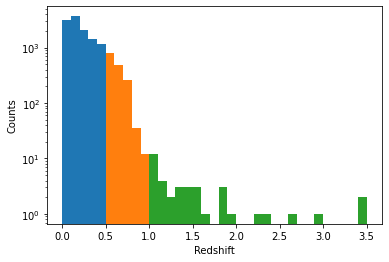

In [22]:
Highz=CIG['redshift']>1
Intermz=logical_and(CIG['redshift']>0.5,CIG['redshift']<=1)
Lowz=CIG['redshift']<=0.5

hist(CIG['redshift'][Lowz],bins=np.linspace(0,0.5,6),log=True)
hist(CIG['redshift'][Intermz],bins=np.linspace(0.5,1,6),log=True)
hist(CIG['redshift'][Highz],bins=np.linspace(1,3.5,26),log=True)
xlabel('Redshift')
ylabel('Counts')

In [23]:
print('The total number of galaxies per sample is: %d for Low-z, %d for Intermediate-z and %d for High-z'%(sum(Lowz),sum(Intermz),sum(Highz)))


The total number of galaxies per sample is: 11502 for Low-z, 1589 for Intermediate-z and 38 for High-z


And finally we save this information in different files to split the runs and avoid computional overwork in CIGALE.

In [24]:
CIG[Lowz].write('CIGPhot_EnergyBal_Lowz.tbl',format='ascii')
CIG[Intermz].write('CIGPhot_EnergyBal_Intz.tbl',format='ascii')
CIG[Highz].write('CIGPhot_EnergyBal_Highz.tbl',format='ascii')
CIG.write('CIGPhot_EnergyBal_All.tbl',format='ascii')

This files are used as an input to CIGALE

In [41]:
np.sum([sum(Lowz),sum(Intermz),sum(Highz)]),np.sum(CIG)

13129